In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
from utils import *
slim = tf.contrib.slim
from tqdm import tqdm_notebook as tqdm
import os 
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from mnist_model import generator,discriminator
import utils
l = tf.layers

/home/data/bruno/anaconda3/envs/tf-1.4-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
"""
idea:
-add ema


conclusion:
-ambient reg on GAN samples is more powerful than unlabeled ambient reg (ie:GAN is a regularizer itself)
-0.001 *consistency_gan_loss

"""

'\nidea:\n-add ema\n\n\nconclusion:\n-ambient reg on GAN samples is more powerful than unlabeled ambient reg (ie:GAN is a regularizer itself)\n-0.001 *consistency_gan_loss\n\n'

## Hyperparam

In [3]:
params = dict(
    batch_size = 100,
    seed = 1234,
    z_dim = 100,
    x_dim = 784,
    reg_w = 0.,
    lr = 1e-4,
    logdir = 'gan_mnist/',
    name_model = 'model_latent100_fc'
)
rng = np.random.RandomState(params['seed'])  # seed labels

In [4]:
params_dnn = dict(
    epsilon = .1,
    gamma = 0.1, #2.
    delta = 0.01,
    batch = 50,
    mc = 200,
    lr=3e-4,
    beta1 = 0.9,
    epoch = 200,
    l2_w = 0.1,
    labeled = 10
)
rng = np.random.RandomState(params['seed'])  # seed labels

## Data creation (unl)

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
trainx = np.vstack([mnist.train.images,mnist.validation.images])
trainy = np.hstack([mnist.train.labels,mnist.validation.labels])
testx = mnist.test.images
testy = mnist.test.labels
trainx = np.reshape(trainx,[-1,28,28,1])
testx = np.reshape(testx,[-1,28,28,1])
trainx_unl = trainx.copy()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


(100, 28, 28, 1) (10000, 28, 28, 1)


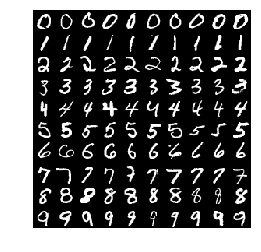

In [6]:
validation = False
if validation:
    split = int(0.1 * trainx.shape[0])
    print(split)
    testx = trainx[:split]
    testy = trainy[:split]
    trainx = trainx[split:]
    trainy = trainy[split:]

trainx_unl = trainx.copy()
inds = rng.permutation(trainx.shape[0])
trainx = trainx[inds]
trainy = trainy[inds]
txs = []
tys = []
for j in range(10):
    txs.append(trainx[trainy == j][:params_dnn['labeled']])
    tys.append(trainy[trainy == j][:params_dnn['labeled']])
txs = np.concatenate(txs, axis=0)
tys = np.concatenate(tys, axis=0)
trainx = txs
trainy = tys


    
nr_batch_train = trainx.shape[0] // params['batch_size']
nr_batch_test = testx.shape[0] // params['batch_size']
print(trainx.shape,testx.shape)
show_digits(trainx[:])
plt.show()

## Build model

In [7]:
tf.reset_default_graph()

In [8]:
unl_dataset = tf.data.Dataset.from_tensor_slices(trainx_unl)
unl_dataset = unl_dataset.shuffle(10000).repeat().batch(params['batch_size'])
iterator_unl = unl_dataset.make_one_shot_iterator()
next_unl = iterator_unl.get_next()

is_training_pl = tf.placeholder(tf.bool, [], name='is_training_pl')
data = tf.cast(next_unl,tf.float32)
noise = tf.random_normal(shape=[params['batch_size'],params['z_dim']])

samples = generator(noise,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
real_score = discriminator(data,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
fake_score = discriminator(samples,is_training=is_training_pl,reuse=tf.AUTO_REUSE)

gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "generator")
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "discriminator") 

loss_g = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.ones_like(fake_score)))
loss_d = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_score,labels=tf.ones_like(fake_score)))+\
tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_score,labels=tf.zeros_like(fake_score)))

optimizer_dis = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5, name='dis_optimizer')
optimizer_gen = tf.train.AdamOptimizer(learning_rate=params['lr'], beta1=0.5, name='gen_optimizer')

update_ops_gen = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='generator')
update_ops_dis = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='discriminator')

with tf.control_dependencies(update_ops_gen): # attached op for moving average batch norm
    traing = optimizer_gen.minimize(loss_g,var_list=gen_vars)
with tf.control_dependencies(update_ops_dis):
    traind = optimizer_dis.minimize(loss_d,var_list=disc_vars)

Tensor("discriminator/layer_3/leaky_relu/sub:0", shape=(?, 4, 4, 512), dtype=float32)
Tensor("discriminator_1/layer_3/leaky_relu/sub:0", shape=(100, 4, 4, 512), dtype=float32)


In [9]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
# tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='my_scope')
saver = tf.train.Saver()

In [10]:
if tf.train.latest_checkpoint(os.path.join('./gan_mnist/')) is not None:
    path = saver.restore(sess, tf.train.latest_checkpoint(os.path.join('./gan_mnist/')))
else:
    print('no model found')

INFO:tensorflow:Restoring parameters from ./gan_mnist/model_latent100_fc


In [11]:
# fs = []
# frames = []
# np_samples = []
# n_batches_viz = 1
# viz_every = 500
# lsd=[]
# lsg=[]
# for i in tqdm(range(10001)):
# #     f, _= sess.run([[loss], train_op],{is_training_pl:True})
#     ld,_=sess.run([loss_d,traind],{is_training_pl:True})
#     lg,_=sess.run([loss_g, traing],{is_training_pl:True})
#     lsd.append(ld); lsg.append(lg);

#     if (i) % viz_every == 0:
#         xx, yy = sess.run([data,samples],{is_training_pl:True})
# #         print('iter nr : ',gstep)
#         plt.figure(figsize=(15,5))
#         plt.subplot(121)
#         show_digits(xx[:100])
#         plt.subplot(122)
#         show_digits(yy[:100])
#         plt.show()


In [12]:
# if not os.path.exists(params['logdir']):
#     os.makedirs(params['logdir'])
# saver.save(sess, os.path.join('./saved_models/',params['logdir'],params['name_model']))
# saver.save(sess, './efficient_model_saved/')


## CNN

## defining model

In [13]:
def lenet(x,training_pl,getter=None):
    with tf.variable_scope("classifier", reuse=tf.AUTO_REUSE, custom_getter=getter):
        x = tf.reshape(x,[-1,28,28,1])
        x = tf.layers.conv2d(x,32,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.layers.conv2d(x,64,5,activation=tf.nn.relu,padding='same')
        x = tf.layers.max_pooling2d(x,2,2)
        x = tf.reshape(x, [-1, 7 * 7 * 64])
        x = tf.layers.dense(x,1024,activation=tf.nn.relu)
        x = tf.layers.dropout(x,rate=0.4,training=training_pl)
        x = tf.layers.dense(x,10)
        return x
    
soft = lambda x: 1/(1+tf.exp(-x))    

In [14]:
inp = tf.placeholder(tf.float32, [params_dnn['batch'], 28,28,1])
lbl = tf.placeholder(tf.int64, [params_dnn['batch']])
training_cnn  = tf.placeholder(tf.bool,[])

logits = lenet(inp,training_cnn)
xloss = tf.losses.sparse_softmax_cross_entropy(logits=logits,labels=lbl)

In [15]:
################ AMBIANT GAN ##############
samp_logits1 = lenet(samples,training_cnn)
p1 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
samp_logits2 = lenet(samples + p1,training_cnn)
p3 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
samp_logits3 = lenet(samples + p3,training_cnn)

consistency_gan = tf.reduce_sum(tf.sqrt(tf.square(samp_logits1-samp_logits2)+1e-8),axis=1)
consistency_gan_loss = tf.reduce_mean(consistency_gan)

ambient_gan = tf.reduce_sum(tf.sqrt(tf.square(samp_logits3-samp_logits2)+1e-8),axis=1)
ambient_gan_loss = tf.reduce_mean(ambient_gan)

# ################ AMBIANT UNL #################

unl = tf.placeholder(tf.float32, [params['batch_size'], 28,28,1])
unl_logits1 = lenet(unl,training_cnn)
p2 = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 
unl_logits2 = lenet(unl+p2,training_cnn)


consistency_unl = tf.reduce_sum(tf.sqrt(tf.square(unl_logits1-unl_logits2)+1e-8),axis=1)
consistency_unl_loss = tf.reduce_mean(consistency_unl)

kl_gan = kl_divergence_with_logit(samp_logits1,samp_logits2)
kl_unl = kl_divergence_with_logit(unl_logits1,unl_logits2)


# ############ MANIFOLD ##########
z1 = tf.random_normal(shape=[params['batch_size'],params['z_dim']])
pert_n = tf.nn.l2_normalize(tf.random_normal(shape=[params['batch_size'],params['z_dim']]),dim=[1])
z1_pert = z1 + 1. * pert_n
pz = tf.random_normal([params['batch_size'],28,28,1],stddev=0.2) 

samp_z1 = generator(z1,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_z2 = generator(z1_pert,is_training=is_training_pl,reuse=tf.AUTO_REUSE)
samp_adv = samp_z1 + 10.* tf.nn.l2_normalize(samp_z2-samp_z1,dim=[1,2,3]) 

logits_z1= lenet(samp_z1,training_cnn)
logits_z2 = lenet(samp_z2+pz,training_cnn)
logits_adv = lenet(samp_adv,training_cnn)

manifold = tf.reduce_sum(tf.sqrt(tf.square(logits_z1-logits_adv)+1e-8),axis=1)
manifold_loss = tf.reduce_mean(manifold)


loss = xloss + 0.001  *manifold_loss
#+ 0.001 * manifold_loss
#+ .0 * consistency_gan_loss + 0. * consistency_unl_loss # + 1. * kl_unl 
#0.001 *consistency_gan_loss

In [16]:
# xx,yy = sess.run([samp_z1,samp_adv],{is_training_pl:False})

In [17]:
# for idx in range(20):
#     plt.subplot(1,2,1)
#     plt.imshow(np.squeeze(xx[idx]),cmap='gray',vmin=0,vmax=1)
#     plt.subplot(1,2,2)
#     plt.imshow(np.squeeze(yy[idx]),cmap='gray',vmin=0,vmax=1)
#     plt.show()

In [18]:
with tf.variable_scope("adam",reuse=tf.AUTO_REUSE):
    optimizer = tf.train.AdamOptimizer(learning_rate=params_dnn['lr'])
    train_op = optimizer.minimize(loss,var_list=tf.trainable_variables(scope='classifier'))

    correct_prediction = tf.equal(tf.argmax(logits,1),lbl)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [19]:
def ema_getter(getter, name, *args, **kwargs):
    var = getter(name, *args, **kwargs)
    ema_var = ema.average(var)
    return ema_var if ema_var else var 

In [20]:
ema = tf.train.ExponentialMovingAverage(decay=0.999)
dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope='classifier')
maintain_averages_op = ema.apply(dvars)

with tf.control_dependencies([train_op]):
    train_op = tf.group(maintain_averages_op)

logits_ema = lenet(inp, training_cnn, getter=ema_getter)
correct_prediction_ema = tf.equal(tf.argmax(logits_ema,1),lbl)
accuracy_ema = tf.reduce_mean(tf.cast(correct_prediction_ema, tf.float32))

In [21]:
# tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)

In [22]:
#init
var = tf.global_variables(scope='classifier')+tf.global_variables(scope='ema')+tf.global_variables(scope='adam')
init_op = tf.variables_initializer(var_list=var)

In [23]:
# [print(v.name) for v in tf.global_variables(scope='ema1')]

## cnn training

In [24]:
sess.run(init_op)

In [25]:
con_loss = []
test_array = [];test_ema = []

length_epoch = 1000
nr_batch_train = length_epoch // params_dnn['batch']
print(nr_batch_train)
print("epoch length:", length_epoch,", batch size:", params_dnn['batch'], 
      ", nr_batch_train:",nr_batch_train, ", mc size:", params['batch_size'],",total grad iter:",length_epoch * params_dnn['epoch'])
for epoch in tqdm(range(200)):
    train_acc=train_loss=test_acc=test_acc_ema=0
    trainx = [];trainy = []
    for t in range(int(np.ceil(length_epoch / float(txs.shape[0])))):  # same size lbl and unlb
        inds = np.random.permutation(txs.shape[0])
        trainx.append(txs[inds])
        trainy.append(tys[inds])
    trainx = np.concatenate(trainx, axis=0)
    trainy = np.concatenate(trainy, axis=0)
    trainx_unl = trainx_unl[rng.permutation(trainx_unl.shape[0])]  # shuffling unl dataset   
#     print(trainx.shape)
    for t in range(nr_batch_train):
#         print(t)
        ran_from = t * params_dnn['batch']
        ran_to = (t + 1) * params_dnn['batch']
        ran_from_mc = t * params['batch_size']
        ran_to_mc = (t + 1) * params['batch_size']
#         print(ran_from,ran_to)

        xl,_,acc,con = sess.run([xloss,train_op,accuracy,manifold_loss],feed_dict={inp: trainx[ran_from:ran_to],
                                                                 lbl: trainy[ran_from:ran_to],
                                                                 unl: trainx_unl[ran_from_mc:ran_to_mc],
                                                                 training_cnn:True,
                                                                 is_training_pl:False})
        train_acc += acc; train_loss += xl; 
        sess.run(maintain_averages_op)
        con_loss.append(con)
    train_acc /= nr_batch_train; train_loss /= nr_batch_train
    
    if epoch % 1 == 0:
        for t in range(nr_batch_test):
            ran_from = t * params_dnn['batch']
            ran_to = (t + 1) * params_dnn['batch']
            xl,acc, acc_ema = sess.run([xloss,accuracy, accuracy_ema],feed_dict={inp: testx[ran_from:ran_to],
                                                                     lbl: testy[ran_from:ran_to],
                                                                     training_cnn:False})
            test_acc += acc; test_acc_ema += acc_ema
        test_acc /= nr_batch_test; test_array.append(test_acc); test_acc_ema /= nr_batch_test; test_ema.append(test_acc_ema)
        print("Epoch: {}, xloss: {:.5f}, training acc: {:.2f}%, test acc: {:.2f}%, test acc ema: {:.2f}%".format(
            epoch, train_loss, train_acc * 100,test_acc*100, test_acc_ema *100))


20
epoch length: 1000 , batch size: 50 , nr_batch_train: 20 , mc size: 100 ,total grad iter: 200000


Epoch: 0, xloss: 1.60430, training acc: 68.40%, test acc: 73.26%, test acc ema: 15.44%
Epoch: 1, xloss: 0.40936, training acc: 90.60%, test acc: 79.46%, test acc ema: 33.02%
Epoch: 2, xloss: 0.11001, training acc: 98.30%, test acc: 81.28%, test acc ema: 52.30%
Epoch: 3, xloss: 0.03613, training acc: 99.90%, test acc: 82.90%, test acc ema: 62.62%
Epoch: 4, xloss: 0.02077, training acc: 100.00%, test acc: 83.14%, test acc ema: 68.10%
Epoch: 5, xloss: 0.01195, training acc: 100.00%, test acc: 83.72%, test acc ema: 71.70%
Epoch: 6, xloss: 0.00871, training acc: 100.00%, test acc: 83.60%, test acc ema: 74.34%
Epoch: 7, xloss: 0.00647, training acc: 100.00%, test acc: 84.12%, test acc ema: 76.06%
Epoch: 8, xloss: 0.00601, training acc: 100.00%, test acc: 84.12%, test acc ema: 77.08%
Epoch: 9, xloss: 0.00527, training acc: 100.00%, test acc: 84.44%, test acc ema: 78.00%
Epoch: 10, xloss: 0.00504, training acc: 100.00%, test acc: 84.22%, test acc ema: 78.66%
Epoch: 11, xloss: 0.00460, training

Epoch: 93, xloss: 0.00089, training acc: 100.00%, test acc: 86.36%, test acc ema: 86.74%
Epoch: 94, xloss: 0.00090, training acc: 100.00%, test acc: 86.64%, test acc ema: 86.72%
Epoch: 95, xloss: 0.00088, training acc: 100.00%, test acc: 86.34%, test acc ema: 86.76%
Epoch: 96, xloss: 0.00087, training acc: 100.00%, test acc: 86.46%, test acc ema: 86.78%
Epoch: 97, xloss: 0.00089, training acc: 100.00%, test acc: 86.52%, test acc ema: 86.74%
Epoch: 98, xloss: 0.00082, training acc: 100.00%, test acc: 86.70%, test acc ema: 86.76%
Epoch: 99, xloss: 0.00081, training acc: 100.00%, test acc: 86.40%, test acc ema: 86.70%
Epoch: 100, xloss: 0.00085, training acc: 100.00%, test acc: 86.04%, test acc ema: 86.64%
Epoch: 101, xloss: 0.00086, training acc: 100.00%, test acc: 86.70%, test acc ema: 86.70%
Epoch: 102, xloss: 0.00079, training acc: 100.00%, test acc: 86.20%, test acc ema: 86.74%
Epoch: 103, xloss: 0.00082, training acc: 100.00%, test acc: 86.14%, test acc ema: 86.74%
Epoch: 104, xloss

Epoch: 185, xloss: 0.00030, training acc: 100.00%, test acc: 66.08%, test acc ema: 78.74%
Epoch: 186, xloss: 0.00032, training acc: 100.00%, test acc: 66.02%, test acc ema: 78.54%
Epoch: 187, xloss: 0.00032, training acc: 100.00%, test acc: 67.08%, test acc ema: 78.22%
Epoch: 188, xloss: 0.00033, training acc: 100.00%, test acc: 67.42%, test acc ema: 77.80%
Epoch: 189, xloss: 0.00028, training acc: 100.00%, test acc: 65.20%, test acc ema: 77.56%
Epoch: 190, xloss: 0.00033, training acc: 100.00%, test acc: 66.18%, test acc ema: 76.98%
Epoch: 191, xloss: 0.00029, training acc: 100.00%, test acc: 62.26%, test acc ema: 76.52%
Epoch: 192, xloss: 0.00029, training acc: 100.00%, test acc: 64.74%, test acc ema: 76.00%
Epoch: 193, xloss: 0.00028, training acc: 100.00%, test acc: 65.30%, test acc ema: 75.54%
Epoch: 194, xloss: 0.00027, training acc: 100.00%, test acc: 62.04%, test acc ema: 75.04%
Epoch: 195, xloss: 0.00027, training acc: 100.00%, test acc: 63.08%, test acc ema: 74.28%
Epoch: 196

In [26]:
# acc_kl_gan = test_array
# acc_vanilla = test_array
# acc_con_unl = test_array
# acc_con_unl_200 = test_array
# unl= test_array
# vanilla = test_array
# ema = test_ema
# manifold=test_array
# manifold_ema=test_ema
# mani_loss = con
# m = test_array
# gan_consist = test_array
# gan_unl = test_array
# manifold_ambient = test_array
# mani_001 = test_array
mani_0001_lr4 = test_array

# vanille = test_array

(0.8, 0.9)

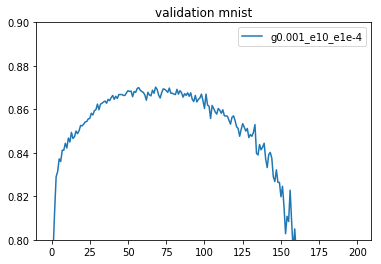

In [27]:
# plt.plot(acc_kl_gan)
# plt.plot(vanilla)
# plt.plot(gan_ambiant)
# plt.plot(acc_con_unl_200)
# plt.plot(unl200)
# plt.plot(gan200)
# plt.plot(unl)
# plt.plot(gan_consist)
# plt.plot(mani_001)
# plt.plot(mani_0005)
# plt.plot(mani_0001)
plt.plot(mani_0001_lr4)

# plt.plot(vanille)
plt.legend(['g0.001_e10_e1e-4','g0.0005_e10_1e-4','g0.0001_e_10lr1e-3','g0.0001_e_10lr1e-4'])
plt.title('validation mnist')
plt.ylim([0.80,0.90])

In [28]:
# plt.plot(acc_kl_gan)
# plt.plot(vanilla)
# plt.plot(gan_ambiant)
# plt.plot(acc_con_unl_200)
# plt.plot(unl200)
# plt.plot(gan200)
# plt.plot(unl)
# plt.plot(gan_consist)
plt.plot(mani_001)
plt.plot(mani_0005)
plt.plot(mani_0001)

# plt.plot(vanille)
plt.legend(['g0.001_e10_e1e-4','g0.0005_e10_1e-4','g0.0001_e_10lr1e-3'])
plt.title('validation mnist')
plt.ylim([0.80,0.90])

NameError: name 'mani_001' is not defined

In [ ]:
plt.plot(con_loss)
plt.title('manifold loss')
plt.show()

In [ ]:
xx,yy=sess.run([samp_z1,samp_z2+pz],{is_training_pl:False})

In [ ]:
for idx in range(10):
    plt.subplot(1,2,1)
    plt.imshow(np.squeeze(xx[idx]),cmap='gray',vmin=0,vmax=1)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(yy[idx]),cmap='gray',vmin=0,vmax=1)
    plt.show()

In [ ]:
# plt.plot(acc_kl_gan)
plt.plot(acc_vanilla)
plt.plot(acc_con_unl_200)
# plt.plot(unl200)
plt.plot(gan200)
plt.plot(gan_unl)
# plt.plot(manifold_ambient)
plt.plot(manifold)
plt.legend(['vanilla','unlabeled ambient','gan ambient','(gan + unlabled) ambient',' gan manifold'])
plt.title('regularization lenet5 (mnist 10 labels)')
plt.xlabel('epoch')
plt.ylim([0.77,0.82])

In [ ]:
sess.run()

In [ ]:
sess.run(manifold,{training_cnn:False,is_training_pl:False})

In [ ]:
plt.plot(con_loss)
plt.title('manifold loss')
plt.show()

In [ ]:
nr_batch_train

In [ ]:
np.asarray([7, 8, 2, 6, 4, 5, 1, 3, 0, 9])